In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
sys.path.append('./utils')
from utils_imports import *
from gpmap import GPMap

# todo: remove pixels from recalc that are in the sea

In [2]:
res = 1
method = "TransformedTargetRegressorWithUncertainty"
tolerance = 3.0
recalc_radius = 800000
region = "world"

In [3]:
points = get_points("dump.sqlite", begin=pd.Timestamp("2024-1-30"), until=pd.Timestamp("2024-3-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y
points.head()

,lat,lon,wait,geometry
0,-5.688317e+06,1.867128e+07,5.0,POINT (18671284.843 -5688317.046)
1,-4.699017e+06,-7.583577e+06,15.0,POINT (-7583577.497 -4699016.755)
2,-4.602671e+06,1.961982e+07,7.0,POINT (19619822.183 -4602670.687)
3,-4.148354e+06,-6.127095e+06,10.0,POINT (-6127094.551 -4148353.673)
4,-4.116196e+06,-6.029002e+06,10.0,POINT (-6029002.261 -4116195.732)


In [4]:
map = MapBasedModel(method=method, region="world", resolution=res, version="diff_mar")
map.get_map_grid()
recalc_radius_pixels = int(np.ceil(abs(recalc_radius / (map.grid[0][0][0] - map.grid[0][0][1]))))
recalc_radius_pixels

8

In [5]:
map.get_landmass_raster()
landmass = map.landmass_raster

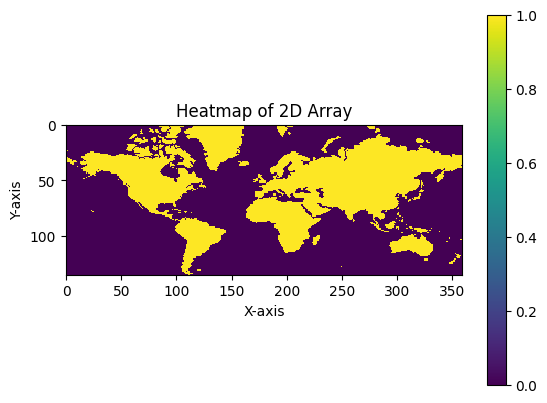

(136, 360)

In [6]:
plt.imshow(landmass, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()
landmass.shape

In [20]:
m = MapBasedModel(method=method, region=region, resolution=res, version="tif")

m.raw_raster = np.ones(map.grid.shape[1:])

m.save_as_raster()

nodata = 0
with rasterio.open(m.rasterio_path) as heatmap:
    start = time.time()
    max_map_wait = heatmap.read().max()
    min_map_wait = heatmap.read().min()

    out_image, out_transform = rasterio.mask.mask(
        heatmap, country_shapes, nodata=nodata
    )
    out_meta = heatmap.meta
    print(f"Time elapsed to transform heatmap: {time.time() - start}")

out_image[0]

AttributeError: 'MapBasedModel' object has no attribute 'save_as_raster'

In [ ]:
# Open the GeoTIFF file
with rasterio.open(new_map_path) as src:
    # Read the first band (assuming single-band raster, adjust for multi-band)
    numpy_array = src.read(1)

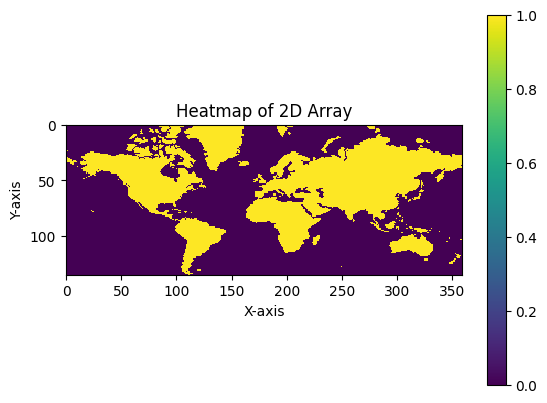

(136, 360)

In [ ]:
plt.imshow(numpy_array, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()
numpy_array.shape

In [11]:
def pixel_from_point(point) -> tuple[int, int]:
    lats = map.Y.transpose()[0]
    lat_index = None
    for i, lat in enumerate(lats):
        if lat >= point["lat"] and point["lat"] >= lats[i+1]:
            lat_index = i
            break

    lons = map.X[0]
    lon_index = None
    for i, lon in enumerate(lons):
        if lon <= point["lon"] and point["lon"] <= lons[i+1]:
            lon_index = i
            break

    return (lat_index, lon_index)

In [12]:
recalc = np.zeros(map.grid.shape[1:])
recalc.shape

(136, 360)

In [13]:
for i, point in points.iterrows():
    lat_pixel, lon_pixel = pixel_from_point(point)

    for i in range(lat_pixel - recalc_radius_pixels, lat_pixel + recalc_radius_pixels):
        for j in range(lon_pixel - recalc_radius_pixels, lon_pixel + recalc_radius_pixels):
            if i < 0 or j < 0 or i >= recalc.shape[0] or j >= recalc.shape[1]:
                continue
            recalc[i, j] = 1

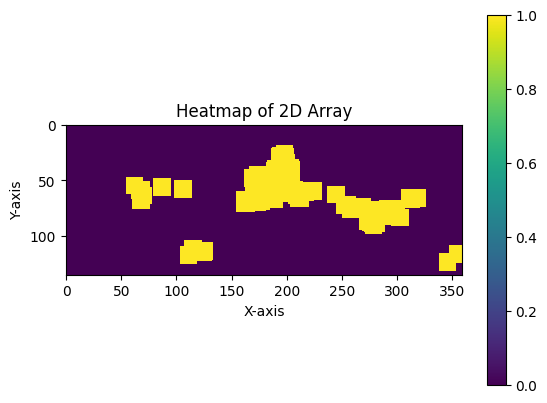

In [14]:
plt.imshow(recalc, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [15]:
recalc_landmass = recalc * landmass

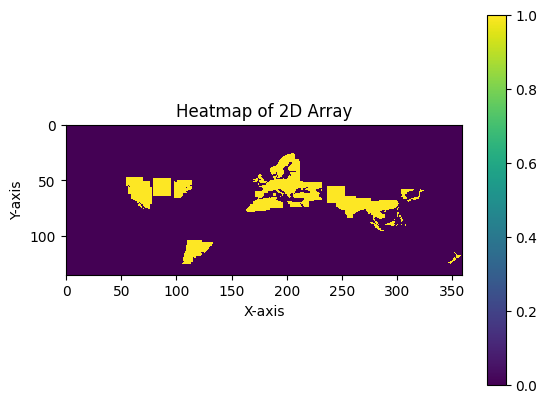

In [16]:
plt.imshow(recalc_landmass, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [17]:
print(recalc.sum(), recalc.shape[0] * recalc.shape[1], recalc.sum() / (recalc.shape[0] * recalc.shape[1]))
print(landmass.sum(), landmass.shape[0] * landmass.shape[1], landmass.sum() / (landmass.shape[0] * landmass.shape[1]))
print(recalc_landmass.sum(), recalc_landmass.shape[0] * recalc_landmass.shape[1], recalc_landmass.sum() / (recalc_landmass.shape[0] * recalc_landmass.shape[1]))

7117.0 48960 0.14536356209150328
16263.0 48960 0.3321691176470588
3948.0 48960 0.08063725490196079


In [41]:
stop

NameError: name 'stop' is not defined

In [18]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-03-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)

fmin_l_bfgs_b
None


Compute rows of pixels...


  0%|          | 0/360 [00:00<?, ?it/s]

Predicting 1000 pixels...
Predicting 1000 pixels...
Predicting 1000 pixels...
Predicting 948 pixels...
Time elapsed to compute full map: 11.270461797714233
For map of shape: (136, 360) that is 48960 pixels and an effective time per pixel of 0.00023020146524204929 seconds
Only 3948.0 pixels were recalculated. That is 8.063725490196079% of the map.
And time per recalculated pixel was 0.002854893635109203 seconds
Loading country shapes...
Time elapsed to load countries: 0.07461118698120117
Transforming heatmap...
max map waiting time: 358.1106053022543
min map waiting time: 1.2554720694135573
Time elapsed to transform heatmap: 0.053763389587402344
Plotting heatmap...


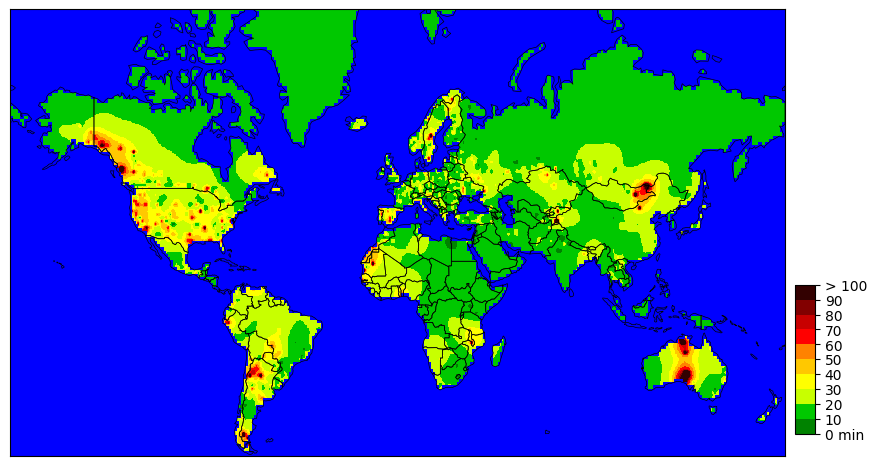

In [44]:
version = "mar_updated"
model = gpr
verbose = True

model_name = type(model).__name__

raster_maker = MapBasedModel(
    method=model_name,
    region=region,
    resolution=res,
    version=version,
    verbose=verbose,
)

jan_map = load_numpy_map(resolution=res, method=method, version="jan")
raster_maker.raw_raster = jan_map

raster_maker.get_map_grid()

# transposing the grid enables us to iterate over it vertically
# and single elements become lon-lat pairs that can be fed into the model
print("Compute rows of pixels...")
start = time.time()
to_predict = []
pixels_to_predict = []
for x, vertical_line in tqdm(
    enumerate(raster_maker.grid.transpose()), total=len(raster_maker.grid.transpose())
):
    for y, coords in enumerate(vertical_line):
        if recalc_landmass[y][x] == 0:
            continue
        this_point = [float(coords[0]), float(coords[1])]
        to_predict.append(this_point)
        pixels_to_predict.append((y, x))
        # batching the model calls
        if len(to_predict) == 1000:
            print(f"Predicting {len(to_predict)} pixels...")
            prediction = model.predict(np.array(to_predict), return_std=False)
            for i, (y, x) in enumerate(pixels_to_predict):
                raster_maker.raw_raster[y][x] = prediction[i]

            to_predict = []
            pixels_to_predict = []
        
print(f"Predicting {len(to_predict)} pixels...")
prediction = model.predict(np.array(to_predict), return_std=False)
for i, (y, x) in enumerate(pixels_to_predict):
    raster_maker.raw_raster[y][x] = prediction[i]

print(f"Time elapsed to compute full map: {time.time() - start}")
print(
    f"For map of shape: {raster_maker.raw_raster.shape} that is {raster_maker.raw_raster.shape[0] * raster_maker.raw_raster.shape[1]} pixels and an effective time per pixel of {(time.time() - start) / (raster_maker.raw_raster.shape[0] * raster_maker.raw_raster.shape[1])} seconds"
)
print((f"Only {recalc_landmass.sum()} pixels were recalculated. That is {recalc_landmass.sum() / (raster_maker.raw_raster.shape[0] * raster_maker.raw_raster.shape[1]) * 100}% of the map."))
print(f"And time per recalculated pixel was {(time.time() - start) / recalc_landmass.sum()} seconds")

save_numpy_map(
    raster_maker.raw_raster,
    region=region,
    method=model_name,
    resolution=res,
    version=version,
)

raster_maker.save_as_raster()
raster_maker.build_map() # for march
a = raster_maker.raw_raster

Loading country shapes...


Time elapsed to load countries: 0.07395505905151367
Transforming heatmap...
max map waiting time: 358.1106053022543
min map waiting time: 1.2574203014004797
Time elapsed to transform heatmap: 0.05422854423522949
Plotting heatmap...


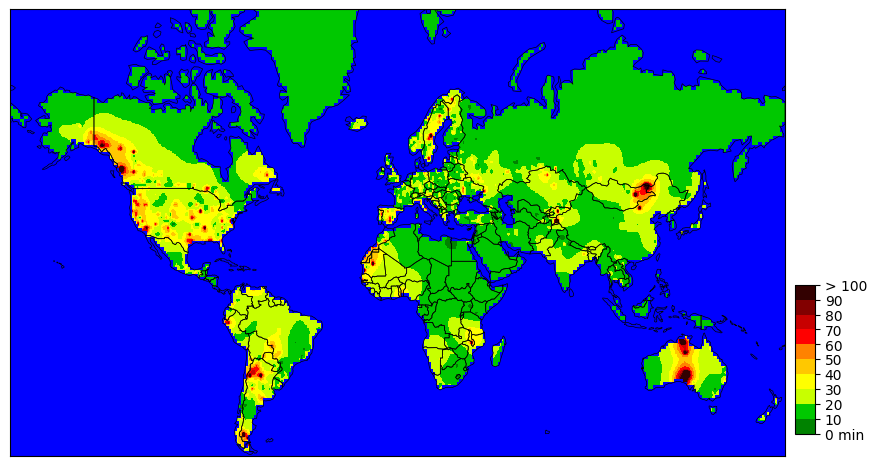

In [45]:
# for january
version = "jan"
verbose = True

model_name = type(model).__name__

raster_maker = MapBasedModel(
    method=model_name,
    region=region,
    resolution=res,
    version=version,
    verbose=verbose,
)
raster_maker.get_map_grid()
jan_map = load_numpy_map(resolution=res, method=method, version="jan")
raster_maker.raw_raster = jan_map
raster_maker.save_as_raster()
raster_maker.build_map()
b = raster_maker.raw_raster

In [49]:
diff = ~np.isclose(a, b, atol=tolerance)

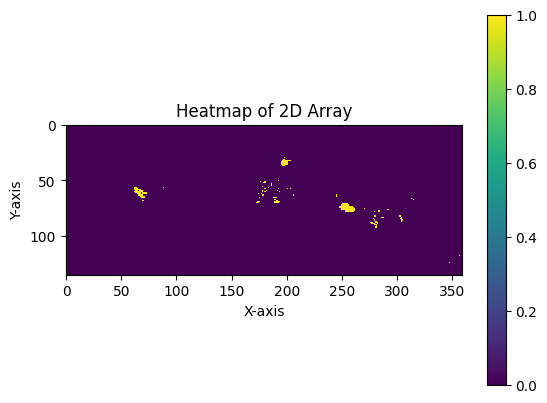

In [50]:
plt.imshow(diff, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [48]:
stop

NameError: name 'stop' is not defined

# high res

In [ ]:
map = GPMap()
map.recalc_map()

In [7]:
print(pd.Timestamp("2024-3-30").date())

2024-03-30


In [3]:
map.build_map()

AttributeError: 'function' object has no attribute 'build_map'

In [7]:
res = 10
method = "TransformedTargetRegressorWithUncertainty"
tolerance = 3.0
recalc_radius = 800000
region = "world"

In [8]:
points = get_points("dump.sqlite", begin=pd.Timestamp("2024-1-30"), until=pd.Timestamp("2024-3-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y
points.head()

,lat,lon,wait,geometry
0,-5.688317e+06,1.867128e+07,5.0,POINT (18671284.843 -5688317.046)
1,-4.699017e+06,-7.583577e+06,15.0,POINT (-7583577.497 -4699016.755)
2,-4.602671e+06,1.961982e+07,7.0,POINT (19619822.183 -4602670.687)
3,-4.148354e+06,-6.127095e+06,10.0,POINT (-6127094.551 -4148353.673)
4,-4.116196e+06,-6.029002e+06,10.0,POINT (-6029002.261 -4116195.732)


In [9]:
map = MapBasedModel(method=method, region=region, resolution=res, version="diff_mar")
map.get_map_grid()
recalc_radius_pixels = int(np.ceil(abs(recalc_radius / (map.grid[0][0][0] - map.grid[0][0][1]))))
recalc_radius_pixels

72

In [10]:
map.get_landmass_raster()
landmass = map.landmass_raster

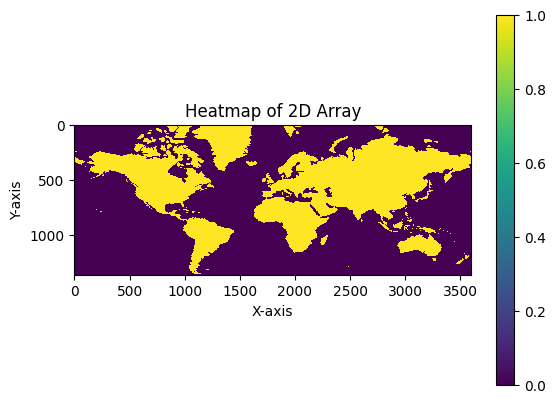

In [11]:
plt.imshow(landmass, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [12]:
def pixel_from_point(point) -> tuple[int, int]:
    lats = map.Y.transpose()[0]
    lat_index = None
    for i, lat in enumerate(lats):
        if lat >= point["lat"] and point["lat"] >= lats[i+1]:
            lat_index = i
            break

    lons = map.X[0]
    lon_index = None
    for i, lon in enumerate(lons):
        if lon <= point["lon"] and point["lon"] <= lons[i+1]:
            lon_index = i
            break

    return (lat_index, lon_index)

In [13]:
recalc = np.zeros(map.grid.shape[1:])
recalc.shape

(1360, 3600)

In [14]:
for i, point in points.iterrows():
    lat_pixel, lon_pixel = pixel_from_point(point)

    for i in range(lat_pixel - recalc_radius_pixels, lat_pixel + recalc_radius_pixels):
        for j in range(lon_pixel - recalc_radius_pixels, lon_pixel + recalc_radius_pixels):
            if i < 0 or j < 0 or i >= recalc.shape[0] or j >= recalc.shape[1]:
                continue
            recalc[i, j] = 1

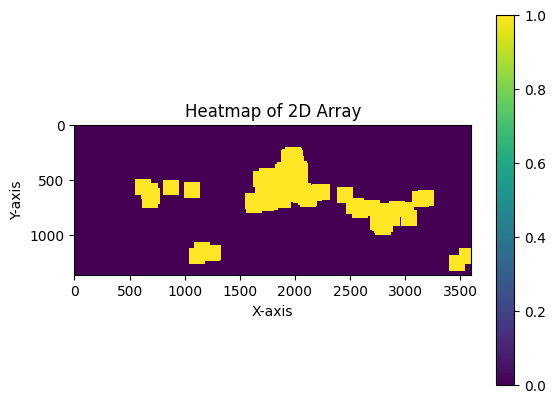

In [15]:
plt.imshow(recalc, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [16]:
recalc_landmass = recalc * landmass

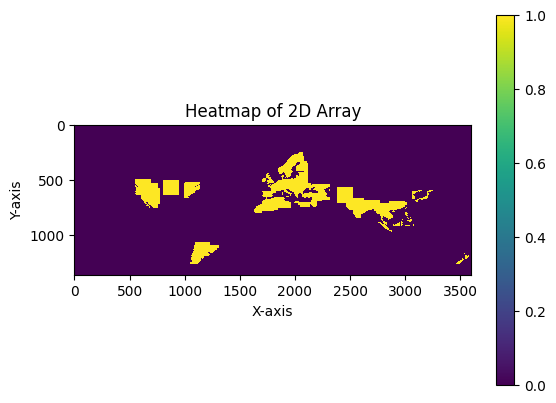

In [17]:
plt.imshow(recalc_landmass, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

In [18]:
print(recalc.sum(), recalc.shape[0] * recalc.shape[1], recalc.sum() / (recalc.shape[0] * recalc.shape[1]))
print(landmass.sum(), landmass.shape[0] * landmass.shape[1], landmass.sum() / (landmass.shape[0] * landmass.shape[1]))
print(recalc_landmass.sum(), recalc_landmass.shape[0] * recalc_landmass.shape[1], recalc_landmass.sum() / (recalc_landmass.shape[0] * recalc_landmass.shape[1]))

629846.0 4896000 0.12864501633986927
1638370.0 4896000 0.3346343954248366
354929.0 4896000 0.0724936683006536


In [19]:
points = get_points("dump.sqlite", until=pd.Timestamp("2024-03-30"))
points["lon"] = points.geometry.x
points["lat"] = points.geometry.y

X = points[["lon", "lat"]].values
y = points["wait"].values
X.shape, y.shape

with open("models/kernel.pkl", "rb") as file:
    gpr = pickle.load(file)
    
print(gpr.regressor.optimizer)
gpr.regressor.optimizer = None
print(gpr.regressor.optimizer)

gpr = fit_gpr_silent(gpr, X, y)

fmin_l_bfgs_b
None


In [20]:
version = "mar_updated"
model = gpr
verbose = True

model_name = type(model).__name__

raster_maker = MapBasedModel(
    method=model_name,
    region=region,
    resolution=res,
    version=version,
    verbose=verbose,
)

jan_map = load_numpy_map(resolution=res, method=method, version="jan")
raster_maker.raw_raster = jan_map

raster_maker.get_map_grid()

print("Compute pixels that are expected to differ...")
start = time.time()
to_predict = []
pixels_to_predict = []
for x, vertical_line in tqdm(
    enumerate(raster_maker.grid.transpose()), total=len(raster_maker.grid.transpose())
):
    for y, coords in enumerate(vertical_line):
        if recalc_landmass[y][x] == 0:
            continue
        this_point = [float(coords[0]), float(coords[1])]
        to_predict.append(this_point)
        pixels_to_predict.append((y, x))
        # batching the model calls
        if len(to_predict) == 10000:
            prediction = model.predict(np.array(to_predict), return_std=False)
            for i, (y, x) in enumerate(pixels_to_predict):
                raster_maker.raw_raster[y][x] = prediction[i]

            to_predict = []
            pixels_to_predict = []
        
prediction = model.predict(np.array(to_predict), return_std=False)
for i, (y, x) in enumerate(pixels_to_predict):
    raster_maker.raw_raster[y][x] = prediction[i]

print(f"Time elapsed to compute full map: {time.time() - start}")
print(
    f"For map of shape: {raster_maker.raw_raster.shape} that is {raster_maker.raw_raster.shape[0] * raster_maker.raw_raster.shape[1]} pixels and an effective time per pixel of {(time.time() - start) / (raster_maker.raw_raster.shape[0] * raster_maker.raw_raster.shape[1])} seconds"
)
print((f"Only {recalc_landmass.sum()} pixels were recalculated. That is {recalc_landmass.sum() / (raster_maker.raw_raster.shape[0] * raster_maker.raw_raster.shape[1]) * 100}% of the map."))
print(f"And time per recalculated pixel was {(time.time() - start) / recalc_landmass.sum()} seconds")

save_numpy_map(
    raster_maker.raw_raster,
    region=region,
    method=model_name,
    resolution=res,
    version=version,
)

raster_maker.save_as_raster()
raster_maker.build_map() # for march
a = raster_maker.raw_raster

Compute pixels that are expected to differ...


  0%|          | 0/3600 [00:00<?, ?it/s]

Time elapsed to compute full map: 816.2991480827332
For map of shape: (1360, 3600) that is 4896000 pixels and an effective time per pixel of 0.0001667278029657657 seconds
Only 354929.0 pixels were recalculated. That is 7.24936683006536% of the map.
And time per recalculated pixel was 0.002299909871063233 seconds


AttributeError: 'MapBasedModel' object has no attribute 'save_as_raster'

Loading country shapes...
Time elapsed to load countries: 0.0734398365020752
Transforming heatmap...
max map waiting time: 545.8306419792199
min map waiting time: 0.9098548905539897
Time elapsed to transform heatmap: 0.15656590461730957
Plotting heatmap...


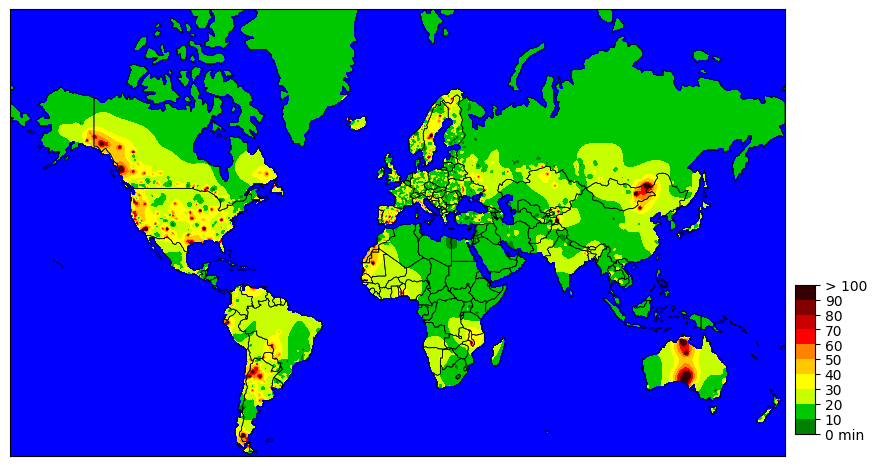

In [20]:
# for january
version = "jan"
verbose = True

model_name = type(model).__name__

raster_maker = MapBasedModel(
    method=model_name,
    region=region,
    resolution=res,
    version=version,
    verbose=verbose,
)
raster_maker.get_map_grid()
jan_map = load_numpy_map(resolution=res, method=method, version="jan")
raster_maker.raw_raster = jan_map
raster_maker.save_as_raster()
raster_maker.build_map()
b = raster_maker.raw_raster

In [21]:
diff = ~np.isclose(a, b, atol=tolerance)

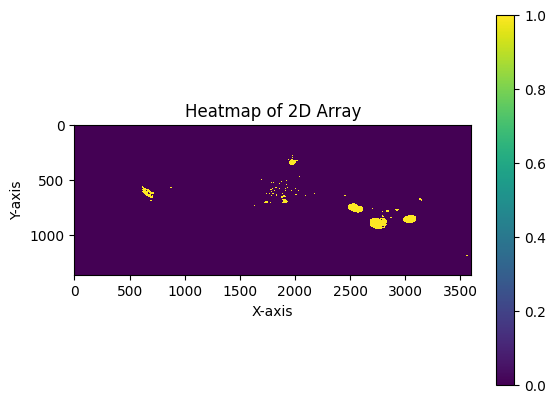

In [22]:
plt.imshow(diff, cmap='viridis', interpolation='nearest')

# Add a color bar to show the scale
plt.colorbar()

# Add labels for better understanding (optional)
plt.title("Heatmap of 2D Array")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

# determine area of map to update around newly added points

Months: jan - mar
Time elapsed to load countries: 0.07320237159729004
Time elapsed to load points: 0.04723334312438965
Time elapsed to transform heatmap: 0.05308055877685547


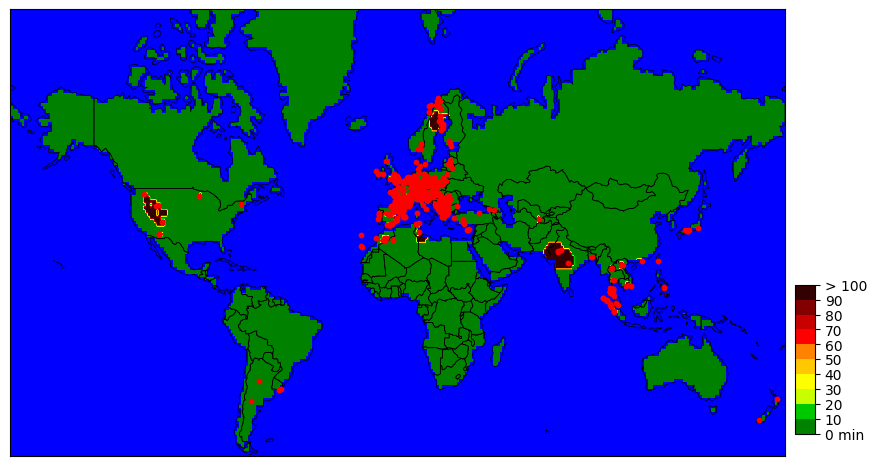

Months: mar - may
Time elapsed to load countries: 0.07260394096374512
Time elapsed to load points: 0.04903364181518555
Time elapsed to transform heatmap: 0.0516514778137207


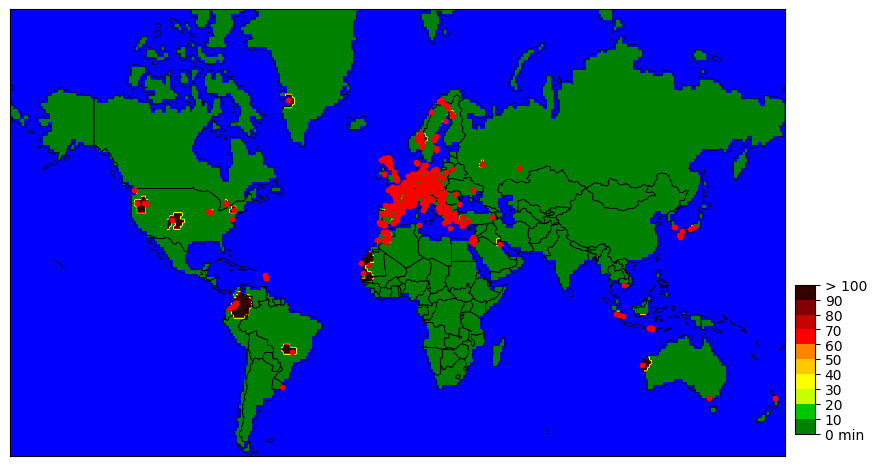

Months: may - jul
Time elapsed to load countries: 0.07197427749633789
Time elapsed to load points: 0.04748129844665527
Time elapsed to transform heatmap: 0.05258679389953613


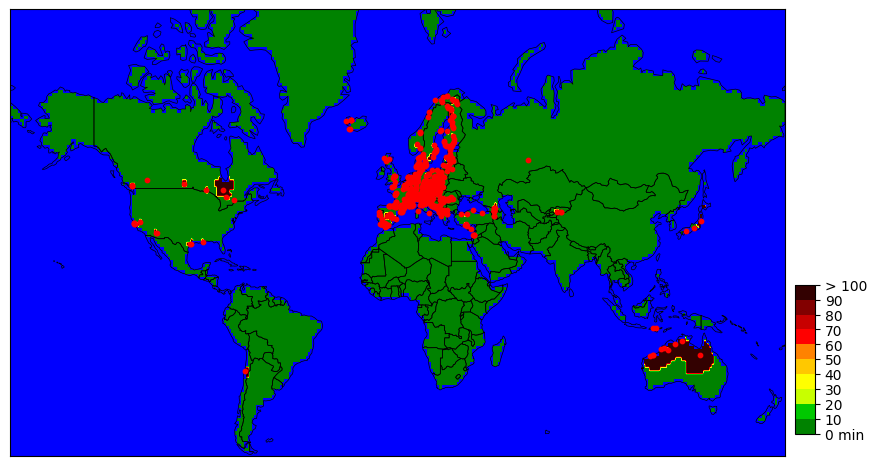

Months: jul - sep
Time elapsed to load countries: 0.0720517635345459
Time elapsed to load points: 0.0697031021118164
Time elapsed to transform heatmap: 0.05218768119812012


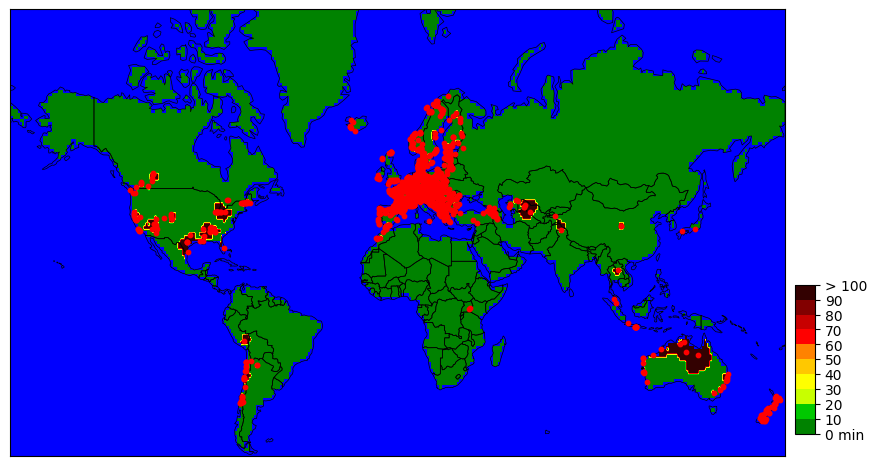

Months: sep - nov
Time elapsed to load countries: 0.07253241539001465
Time elapsed to load points: 0.04851889610290527
Time elapsed to transform heatmap: 0.05156755447387695


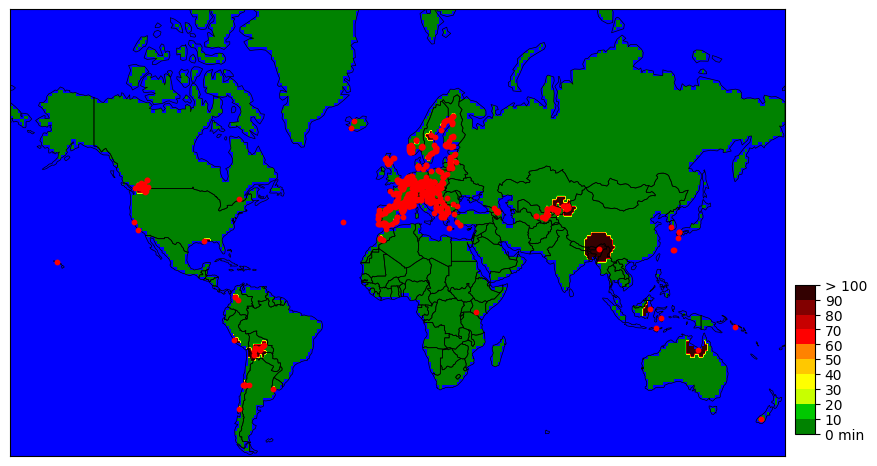

In [81]:
months = ["jan", "mar", "may", "jul", "sep", "nov"]
dates = ["2024-1-30", "2024-3-30", "2024-5-30", "2024-7-30", "2024-9-30", "2024-11-30"]

for i in range(5):
    print(f"Months: {months[i]} - {months[i+1]}")
    points = get_points("dump.sqlite", begin=pd.Timestamp(dates[i]), until=pd.Timestamp(dates[i+1]))
    points["lon"] = points.geometry.x
    points["lat"] = points.geometry.y

    map1 = load_numpy_map(resolution=res, method=method, version=months[i])
    map2 = load_numpy_map(resolution=res, method=method, version=months[i+1])
    diff = ~np.isclose(map1, map2, atol=tolerance)
    diff = diff * 100

    map = MapBasedModel(method=method, region="world", resolution=res, version="diff_mar")
    map.raw_raster = diff
    map.get_map_grid()
    map.save_as_raster()
    map.build_map(points=points, show_points=True)